In [1]:
import os
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('paper', font_scale=1.1)
import pandas as pd
import warnings
import sys
import dabest
import matplotlib as mpl
import scipy.stats as st
from mpl_toolkits.axes_grid1 import make_axes_locatable


warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
DirectoryName = '/Users/seetha/Box Sync/MultiDayData/Data/'
CombinedFolderName = '/Users/seetha/Box Sync/MultiDayData/PlaceCellResultsAll/'
SaveFigureFolder = '/Users/seetha/Box Sync/MultiDayData/MultiDayPaper/Figures/FigurepanelsPDF/CommonPCs/'

In [3]:
from numplacecells import GetData as gd

In [4]:
taskstoplot = ['Task1', 'Task2', 'Task3', 'Task4', 'Task5']
num = gd(FolderName=DirectoryName, CombinedDataFolder=CombinedFolderName, taskstoplot=taskstoplot)

Index(['Task', 'CellNumber', 'PlaceCellNumber', 'NumPlacecells', 'COM',
       'WeightedCOM', 'Precision', 'Precision_rising', 'Width', 'FiringRatio',
       'Firingintensity', 'Reliability', 'animalname'],
      dtype='object')


In [5]:
commondf = num.updateddf[num.updateddf['CommonCells']]

In [7]:
numcelldict = {k:[] for k in ['Task', 'animalname', 'CellNumber', 'NumPlacecells']}
for a in num.animals:
    df = commondf[commondf['animalname']==a]
    numcells = df['CellNumber'].unique()
    for c in numcells:
        for t in taskstoplot:
            numcelldict['Task'].append(t)
            numcelldict['CellNumber'].append(c)
            numcelldict['animalname'].append(a)
            numplacecells = df[(df['Task']==t) & (df['CellNumber']==c)]['NumPlacecells'].to_numpy()
            if len(numplacecells):
                numcelldict['NumPlacecells'].append(numplacecells[0])
            else:
                numcelldict['NumPlacecells'].append(np.nan)

In [8]:
numcelldf = pd.DataFrame.from_dict(numcelldict)
numcelldf = numcelldf.pivot(index=['animalname', 'CellNumber'], columns=['Task'], values=['NumPlacecells'])
numcelldf = numcelldf.reset_index() #.dropna() #.droplevel(level=0, axis=1)

In [9]:
#Total place cells per animal
numtotalplacecells = []
for a in num.animals:
    pfparams = np.load(
        os.path.join(DirectoryName, a, 'PlaceCells', f'%s_placecell_data.npz' % a), allow_pickle=True)
    celllist = []
    for t in taskstoplot:
        celllist.extend(pfparams['sig_PFs_cellnum_revised'].item()[t])
    numtotalplacecells.append(len(set(celllist)))
#Find place cells common among all
numcells = []
for a in np.unique(numcelldf['animalname']):
    numcells.append(len(numcelldf[numcelldf['animalname']==a]))

In [19]:
#Total imaged cells
numtotalcells = []
for a in num.animals:
    pfparams = np.load(
        os.path.join(DirectoryName, a, 'PlaceCells', f'%s_placecell_data.npz' % a), allow_pickle=True)
    numtotalcells.append(pfparams['numcells'])

In [23]:
data = numtotalcells
ci = st.norm.interval(alpha=0.99, loc=np.mean(data), scale=st.sem(data))
print(np.mean(data), ci[0])

1376.0 622.7432116868305


In [89]:
data = np.array(numcells)/np.array(numtotalplacecells)*100
print(np.mean(data))
ci = st.norm.interval(alpha=0.99, loc=np.mean(data), scale=st.sem(data))
# print(ci[0])
print(np.mean(data)-ci[0], np.mean(data)-ci[1])

25.393759130885606
22.90695980199272 -22.90695980199272


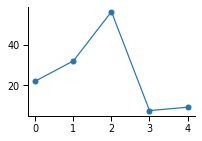

In [81]:
fs, ax = plt.subplots(1, figsize=(3, 2))
ax.plot(data, '.-', markersize=10)
sns.despine(ax=ax)
fs.savefig(os.path.join(SaveFigureFolder, 'Numplacecell_peranimal.pdf'), bbox_inches='tight')

(322, 5)
(255, 5)
(577, 5)
(577, 5)


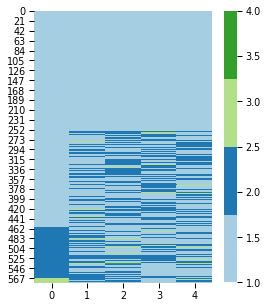

In [69]:
fs, ax = plt.subplots(1, figsize=(4, 5))
temp = numcelldf[taskstoplot]
mat1 = temp.loc[(temp!=1).any(axis=1)].to_numpy()
idx = np.argsort(mat1[:, 0])
mat1 = mat1[idx, :]
print(mat1.shape)

mat2 = temp.loc[(temp==1).all(axis=1)].to_numpy()
mat = np.vstack((mat2, mat1))
print(mat2.shape)
print(mat.shape)
print(temp.shape)

sns.heatmap(mat, cmap=sns.color_palette('Paired', 4), ax=ax)
fs.savefig(os.path.join(SaveFigureFolder, 'Placecellfate_multicells.tiff'), bbox_inches='tight', dpi=300)

In [73]:
mat1 = temp.loc[(temp!=1).any(axis=1)]
subset = mat1[mat1['Task1']==1]

[[  0.   1.   2.]
 [142.  59.   4.]]
[[ 0.  1.  2.]
 [98. 98.  9.]]
[[  0.   1.   2.]
 [103.  94.   8.]]
[[  0.   1.   2.]
 [128.  72.   5.]]


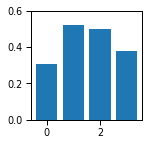

In [81]:
fs, ax = plt.subplots(1)
prob = []
for t in taskstoplot[1:]:
    diff = subset[t] - subset['Task1']
    counts = np.array(np.unique(diff, return_counts=True))
    print(counts)
    prob.append(np.sum(counts[1, 1:])/np.sum(counts[1, :]))
ax.bar(np.arange(4), prob)
ax.set_ylim((0, 0.6))
ax.locator_params(axis='y', nbins=3)
fs.set_size_inches((2, 2))
fs.savefig(os.path.join(SaveFigureFolder, 'Probabilityofplacecellincrease.pdf'), bbox_inches='tight', dpi=300)

In [27]:
df = num.get_placecell_perc_peranimal(taskstoplot)
df['Numplacecells'].sum()

9155